# **COMPUTER VISION**

**UNIVERSIDAD MILITAR NUEVA GRANADA**

**COMPUTER VISION - PERCEPTRON MULTICAPA**

Ingeniería en Telecomunicaciones

Edwin Pineda - - Javier Muñoz

In [1]:
!pip install medmnist
!pip install optuna   #Herramienta para seleccionar hiperparametros

In [2]:
# Carga de librerías
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt

# Carga de módulos
from medmnist import BloodMNIST
import random
import matplotlib.pyplot as plt
import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import optuna
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Dataset

MNIST dataset

[https://medmnist.com/](https://medmnist.com/)Dataset BloodMNIST


In [3]:
# Carga del dataset BloodMNIST
train_dataset = BloodMNIST(split="train", download=True, size=28)
test_dataset = BloodMNIST(split="test", download=True, size=28)
validation_dataset=BloodMNIST(split="val", download=True, size=28)

x_train, y_train = train_dataset.imgs, train_dataset.labels
x_test, y_test = test_dataset.imgs, test_dataset.labels
x_validation, y_validation = validation_dataset.imgs, validation_dataset.labels

print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)
print ("Shape of x_validation:", x_validation.shape)
print("Shape of y_validation:", y_validation.shape)

Shape of x_train: (11959, 28, 28, 3)
Shape of y_train: (11959, 1)
Shape of x_test: (3421, 28, 28, 3)
Shape of y_test: (3421, 1)
Shape of x_validation: (1712, 28, 28, 3)
Shape of y_validation: (1712, 1)


Reshape a un tesor de 4 dimensiones: batch size, width, height, color channels (método reshape sobre datos (X) de entrenamiento)

In [4]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 3)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 3)
print(f"Shape of x_train after reshaping: {x_train.shape}")
print(f"Shape of x_test after reshaping: {x_test.shape}")

Shape of x_train after reshaping: (11959, 28, 28, 3)
Shape of x_test after reshaping: (3421, 28, 28, 3)


Normalizar Datos de entrada: uint8 (0-255)

In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Convertir etiquetas a one-hot-encoding (categóricas)

In [6]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Uso de la herramienta para la selección de hiperparámetros

In [23]:
#Datos de entrenamiento
x_train_Mod = x_train[1:11959,:,:,:]
y_train_Mod = y_train[1:11959,:]

def objective(trial):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 3)))

    # Primera capa
    units_1 = trial.suggest_int('units_1', 128, 1024, step=8)
    act_1 = trial.suggest_categorical('act_1', ['relu', 'tanh', 'sigmoid', 'selu'])
    model.add(Dense(units_1, activation=act_1))

    # Segunda capa
    units_2 = trial.suggest_int('units_2', 64, 1024, step=8)
    act_2 = trial.suggest_categorical('act_2', ['relu', 'sigmoid', 'tanh'])
    model.add(Dense(units_2, activation=act_2))

    # Capa de salida
    model.add(Dense(8, activation='softmax'))

    # Optimizer
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    optimizer = Adam(learning_rate=lr)

    # Batch size
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    # Entrenamiento silencioso
    history = model.fit(x_train_Mod, y_train_Mod,
                        validation_split=0.2,
                        epochs=10,
                        batch_size=batch_size,
                        verbose=0)

    val_acc = max(history.history['val_categorical_accuracy'])
    return val_acc

#Crear y ejecutar estudio
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

#Mostrar mejores parámetros
print("🔍 Mejores hiperparámetros encontrados:")
print(study.best_params)

[I 2025-08-23 15:43:11,038] A new study created in memory with name: no-name-4397d5d6-fb73-4974-9576-0f071e691327
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-08-23 15:43:25,102] Trial 0 finished with value: 0.8072742223739624 and parameters: {'units_1': 840, 'act_1': 'sigmoid', 'units_2': 768, 'act_2': 'tanh', 'lr': 0.0006457043642896064, 'batch_size': 64}. Best is trial 0 with value: 0.8072742223739624.
[I 2025-08-23 15:43:42,618] Trial 1 finished with value: 0.821906328201294 and parameters: {'units_1': 808, 'act_1': 'selu', 'units_2': 568, 'act_2': 'tanh', 'lr': 0.00015485492349432775, 'batch_size': 32}. Best is trial 1 with value: 0.821906328201294.
[I 2025-08-23 15:43:54,064] Trial 2 finished with value: 0.7366220951080322 and

🔍 Mejores hiperparámetros encontrados:
{'units_1': 808, 'act_1': 'selu', 'units_2': 568, 'act_2': 'tanh', 'lr': 0.00015485492349432775, 'batch_size': 32}


# Modelos (variación de Hiperparámetros)

# Compilación y entrenamiento del modelo

In [32]:
#Intento 1 Sin uso de la herramienta    #85%
x_train_Mod = x_train[1:11959,:,:,:] #8356 a 16
y_train_Mod = y_train[1:11959,:]

#Hiperparámetros
batch_s, lr, num_epochs = 16, 0.0005, 30
optimizerf = tf.keras.optimizers.Adam(learning_rate=lr)

#Modelo
model = Sequential([
                    Flatten(),  # 28*28=784
                    Dense(240, activation='relu'),
                    Dense(192, activation='sigmoid'),
                    Dense(8, activation='softmax')
])

In [54]:
#Intento 2 Sin la herramienta   #82%
#Modelo 6 (regulariza)
#Datos
x_train_Mod = x_train[1:11959,:,:,:]
y_train_Mod = y_train[1:11959,:]
#Hiperparámetros
batch_s, lr, num_epochs = 32, 0.001, 30
optimizerf = tf.keras.optimizers.Adam(learning_rate=lr)

#Modelo
model = Sequential([
                    Flatten(),  # 28*28=784
                    Dense(128, activation='relu'),
                    Dense(8, activation='softmax')
])

In [35]:
#Intento 3 Con la herramienta    #87%
#Datos
x_train_Mod = x_train[1:11959,:,:,:]
y_train_Mod = y_train[1:11959,:]
weight_decay1 = 0.000001
#Hiperparámetros
batch_s, lr, num_epochs = 16, 3.568382753188613e-05, 30
optimizerf = tf.keras.optimizers.Adam(learning_rate=lr)

#Modelo
model = Sequential([
                    Flatten(),  # 28*28=784
                    Dense(832, activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(weight_decay1)),
                    Dense(512,activation="relu"),
                    Dense(8, activation='softmax')
])

In [55]:
model.compile(
  optimizer=optimizerf,
  loss= 'categorical_crossentropy',
  metrics=['CategoricalAccuracy']
)

# Entrenamiento

In [56]:
history = model.fit(
    x_train_Mod,
    y_train_Mod,
    epochs=num_epochs,
    batch_size=batch_s,
    validation_data=(x_test, y_test))

Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - CategoricalAccuracy: 0.3747 - loss: 1.7840 - val_CategoricalAccuracy: 0.6513 - val_loss: 1.0363
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - CategoricalAccuracy: 0.6530 - loss: 0.9993 - val_CategoricalAccuracy: 0.6875 - val_loss: 0.9068
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - CategoricalAccuracy: 0.6921 - loss: 0.8976 - val_CategoricalAccuracy: 0.7270 - val_loss: 0.8034
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - CategoricalAccuracy: 0.7091 - loss: 0.8307 - val_CategoricalAccuracy: 0.7214 - val_loss: 0.7963
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - CategoricalAccuracy: 0.7317 - loss: 0.7897 - val_CategoricalAccuracy: 0.7264 - val_loss: 0.7680
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - CategoricalAccuracy: 0.7477 - loss: 0.7471 - val_CategoricalAccuracy: 0.7556 - val_loss: 0.7092
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - CategoricalAccuracy: 0.7498 - loss: 0.7167 - v

In [41]:
model.summary()

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_51 (Flatten)            │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 832)            │     1,957,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 512)            │       426,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,164,890 (27.33 MB)

 Trainable params: 2,388,296 (9.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,776,594 (18.22 MB)

# Evolución del algoritmo

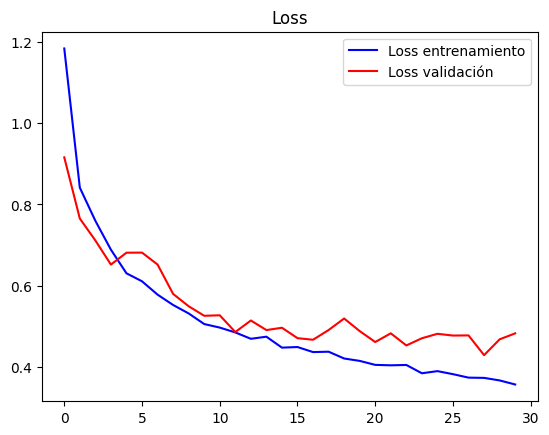

In [43]:
# Gráfica de pérdida
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Loss entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Loss validación')
plt.title('Loss')
plt.legend()
plt.show()

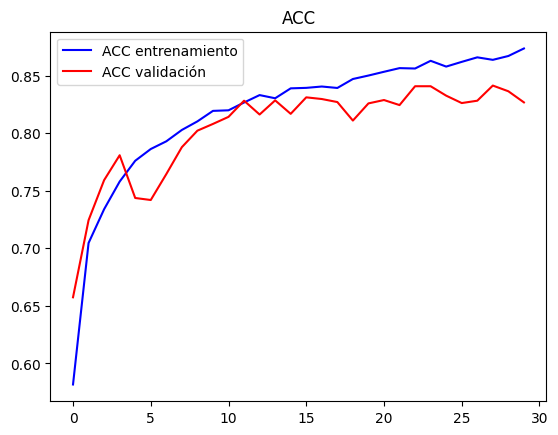

In [42]:
# Gráfica de Accuracy
import matplotlib.pyplot as plt
acc = history.history['CategoricalAccuracy']
val_acc = history.history['val_CategoricalAccuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='ACC entrenamiento')
plt.plot(epochs, val_acc, 'r', label='ACC validación')
plt.title('ACC')
plt.legend()
plt.show()

# Prueba del modelo

Imagen seleccionada al azar de los datos de prueba (datos que no concoció el modelo cuando fue entrenado)

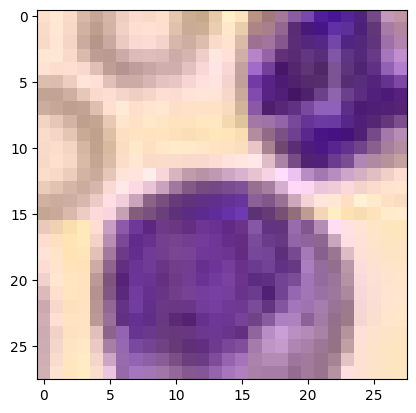

In [51]:
import random
image = random.choice(x_test)
plt.imshow(image)
plt.show()

Reshape y normalizar la imagen (como se hizo en el pre-procesamiento del dataset)

In [52]:
image = (image.reshape((1, 28, 28, 3))).astype('float32')

Predecir la clase de la imagen (el resultado se tiene que adaptar... one-hot-encoding)

In [53]:
class_names = [
    "Basófilo",             # 0
    "Eosinófilo",           # 1
    "Eritroblasto",         # 2
    "Granulocito inmaduro", # 3
    "Linfocito",            # 4
    "Monocito",             # 5
    "Neutrófilo",           # 6
    "Plaqueta"              # 7
]
digit = np.argmax(model.predict(image)[0], axis=-1)
print("Prediction: ", class_names[digit])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction:  Basófilo
